In [3]:
import random

import bt
import pandas as pd

%matplotlib inline

In [ ]:
'''
단타 종목 손절 -6% / 트레일링 +12% / 스탑 -4%
중타 종목 손절 -10% / 트레일링 +20% / 스탑 - 5%
장타 종목 손절 -15% / 트레일링 +25% / 스탑 - 6%
'''

def kelly_betsize(p, b):
    """
    Calculate the Kelly Criterion for a given probability of winning and odds.
    
    Parameters:
    p (float): Probability of winning (between 0 and 1).
    b (float): Odds received on the bet (e.g., 2.0 for even money).
    
    Returns:
    float: Fraction of bankroll to bet according to the Kelly Criterion.
    """
    return (p * b - (1 - p)) / b


def kelly_rr_ratio(p, f):
    """
    Calculate the Kelly Criterion for a given probability of winning and fraction of bankroll to bet.
    
    Parameters:
    p (float): Probability of winning (between 0 and 1).
    f (float): Fraction of bankroll to bet (between 0 and 1).
    
    Returns:
    float: Kelly Criterion ratio.
    """
    return (p - 1) / (f - p)

In [43]:
kelly_betsize(0.5, 1.333333333333333333333333333333)

0.12499999999999997

In [36]:
kelly_rr_ratio(0.4, 0.1)

1.9999999999999996

In [457]:
class WeighSMADisparity(bt.Algo):
    def __init__(self, sma_period=60, **weights):
        super(WeighSMADisparity, self).__init__()
        self.sma_period = sma_period
        self.weights = weights

    def __call__(self, target):
        selected = target.temp.get('selected', [])
        if not selected: # 선택된 자산 없으면 종료
            target.temp['weights'] = {}
            return True
        
        prices = target.universe.loc[:target.now, selected]
        if len(prices) < self.sma_period:  # 데이터 부족 시 기존 weights 유지
            target.temp["weights"] = self.weights.copy()
            return True
        
        weights = pd.Series(self.weights)
        
        smas = prices.rolling(window=self.sma_period, min_periods=self.sma_period).mean().iloc[-1]
        current_prices = prices.iloc[-1]
        disparities = (current_prices / smas).fillna(0).clip(lower=0)
        ratios = 1 - disparities / disparities.sum()

        scaled_weights = ratios * weights
        weights = scaled_weights / scaled_weights.sum()
        target.temp["weights"] = weights.fillna(0).to_dict()
        return True

In [ ]:
data = bt.get('qqq, qld, tqqq, schd, ltpz, iau, bil', start='2017-01-01', end='2025-04-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [517]:
s1 = bt.Strategy('s1', [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighSpecified(qld=0.25, schd=0.25, ltpz=0.20, iau=0.20, bil=0.10),
                       bt.algos.Rebalance()])

s2 = bt.Strategy('s2', [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighSpecified(qld=0.2, schd=0.8),
                       bt.algos.Rebalance()])

s3 = bt.Strategy('s3', [bt.algos.RunQuarterly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighSpecified(tqqq=0.2, schd=0.8),
                       bt.algos.Rebalance()])

s4 = bt.Strategy('s4', [
    bt.algos.RunQuarterly(),        # 분기 첫 거래일에 아래 알고리즘들 실행
    bt.algos.SelectAll(),           # 모든 티커 선택
    WeighSMADisparity(sma_period=60, qld=0.2, schd=0.8),
    bt.algos.Rebalance()            # 목표 가중치에 맞춰 포트폴리오 리밸런싱
])

100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


<Axes: title={'center': 'Equity Progression'}>

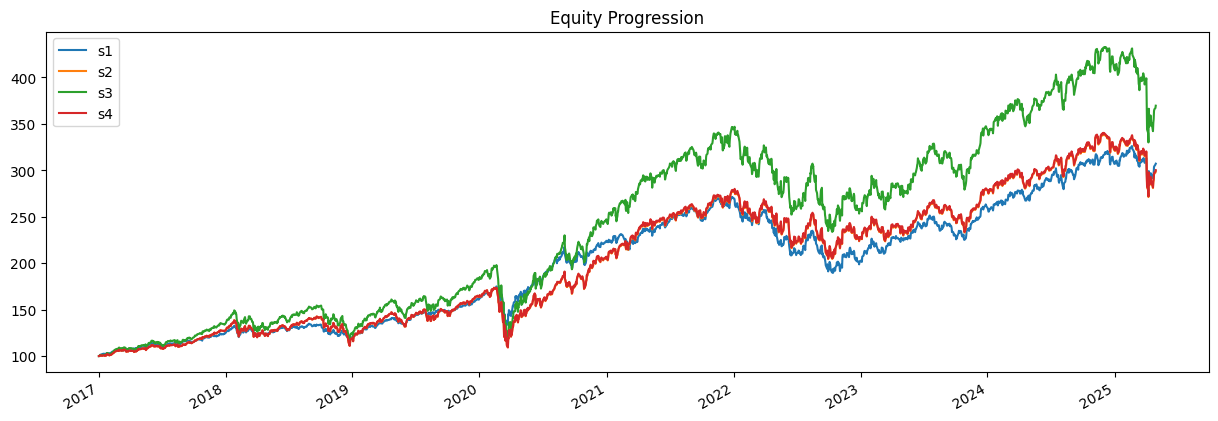

In [518]:
tests = [bt.Backtest(s1, data), bt.Backtest(s2, data), bt.Backtest(s3, data), bt.Backtest(s4, data)]
res = bt.run(*tests)
res.plot()

In [519]:
res.display()

Stat                 s1          s2          s3          s4
-------------------  ----------  ----------  ----------  ----------
Start                2017-01-02  2017-01-02  2017-01-02  2017-01-02
End                  2025-04-29  2025-04-29  2025-04-29  2025-04-29
Risk-free rate       0.00%       0.00%       0.00%       0.00%

Total Return         207.10%     199.13%     269.52%     200.12%
Daily Sharpe         0.93        0.72        0.75        0.72
Daily Sortino        1.47        1.11        1.15        1.11
CAGR                 14.44%      14.08%      17.01%      14.12%
Max Drawdown         -30.16%     -37.03%     -41.78%     -36.97%
Calmar Ratio         0.48        0.38        0.41        0.38

MTD                  -1.17%      -6.06%      -6.90%      -6.04%
3m                   -2.66%      -9.34%      -12.03%     -9.31%
6m                   -1.41%      -7.72%      -10.24%     -7.68%
YTD                  0.08%       -6.97%      -9.59%      -6.94%
1Y                   12.60%      3.

In [25]:
data = bt.get('qqq, qld, tqqq, schd, ltpz, iau, bil', start='2015-08-01', end='2025-04-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [29]:
tests = []
for test in range(10):
    weights = {"tqqq": 0.1 * test, "bil": 1 - 0.1 * test}
    print(weights)
    strategy = bt.Strategy(f"s{test+1}", [
        bt.algos.RunQuarterly(),
        bt.algos.SelectAll(),
        bt.algos.WeighSpecified(**weights),
        bt.algos.Rebalance()
    ])
    tests.append(bt.Backtest(strategy, data))

{'tqqq': 0.0, 'bil': 1.0}
{'tqqq': 0.1, 'bil': 0.9}
{'tqqq': 0.2, 'bil': 0.8}
{'tqqq': 0.30000000000000004, 'bil': 0.7}
{'tqqq': 0.4, 'bil': 0.6}
{'tqqq': 0.5, 'bil': 0.5}
{'tqqq': 0.6000000000000001, 'bil': 0.3999999999999999}
{'tqqq': 0.7000000000000001, 'bil': 0.29999999999999993}
{'tqqq': 0.8, 'bil': 0.19999999999999996}
{'tqqq': 0.9, 'bil': 0.09999999999999998}


In [30]:
res = bt.run(*tests)

100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


In [31]:
res.display()

Stat                 s1          s2          s3          s4          s5          s6          s7          s8          s9          s10
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02
End                  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         18.98%      84.40%      171.60%     281.57%     412.38%     558.36%     709.52%     851.64%     967.37%     1038.38%
Daily Sharpe         6.79        0.99        0.85        0.81        0.78        0.76        0.75        0.74        0.73        0.72
Daily Sortino        16.02       1.55  

In [28]:
res.display()

Stat                 s1          s2          s3          s4          s5          s6          s7          s8          s9          s10
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02  2015-08-02
End                  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29  2025-04-29
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         133.80%     183.28%     238.70%     299.79%     366.03%     436.64%     510.52%     586.30%     662.35%     736.73%
Daily Sharpe         0.59        0.66        0.70        0.72        0.73        0.74        0.74        0.74        0.73        0.73
Daily Sortino        0.93        1.02   

<Axes: title={'center': 'Equity Progression'}>

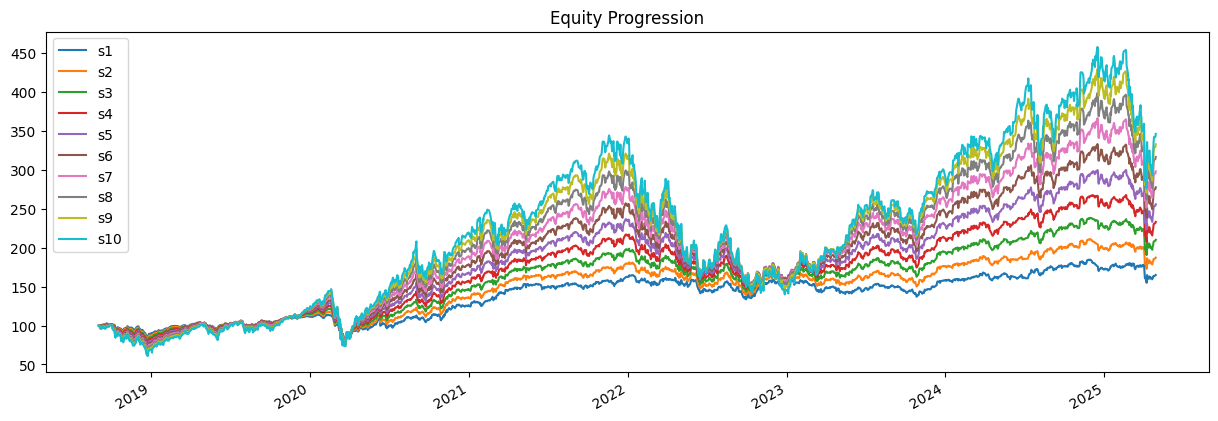

In [24]:
res.plot()